# 1. VHM Dataset

In [17]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('1-VHM Historical Data.csv')
df_reversed = df.iloc[::-1].reset_index(drop=True)
df1 = df_reversed['Price']
# Remove commas and convert to float
df1 = df1.str.replace(',', '').astype(float)
df1

0       68421.0
1       70075.0
2       68421.0
3       69022.0
4       69173.0
         ...   
1247    43350.0
1248    44200.0
1249    44400.0
1250    43400.0
1251    43950.0
Name: Price, Length: 1252, dtype: float64

In [19]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [20]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [21]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [22]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [23]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [24]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [25]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 40ms/step - loss: 0.0872 - val_loss: 0.0024
Epoch 2/100
13/13 [==============================] - 0s 22ms/step - loss: 0.0140 - val_loss: 0.0107
Epoch 3/100
13/13 [==============================] - 0s 28ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 4/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 5/100
13/13 [==============================] - 0s 22ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 6/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 7/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 8/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 9/100
13/13 [==============================] - 0s 21ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 10/100
13/13 [==============================] - 0s 21ms/step - loss: 0.0020 - val_loss: 0.0025

In [26]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 26ms/step


In [27]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [28]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 44991.434934406105
Testing RMSE: 52717.137213824826


In [29]:
# 13. Dự báo 30 ngày tiếp theo
x_input = val_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

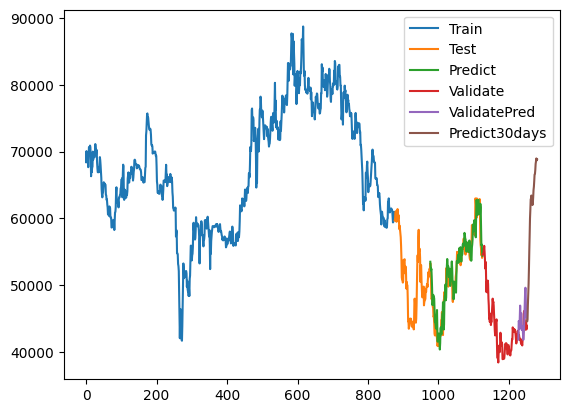

In [30]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# 2. NVL Dataset

In [31]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('2-NVL Historical Data.csv')
df_reversed = df.iloc[::-1].reset_index(drop=True)
df1 = df_reversed['Price']
# Remove commas and convert to float
df1 = df1.str.replace(',', '').astype(float)
df1

0       32933.0
1       33100.0
2       32711.0
3       31709.0
4       31932.0
         ...   
1247    16800.0
1248    17050.0
1249    17000.0
1250    17100.0
1251    17300.0
Name: Price, Length: 1252, dtype: float64

In [33]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [34]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [35]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [36]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [37]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [38]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [39]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 65ms/step - loss: 0.0718 - val_loss: 0.0162
Epoch 2/100
13/13 [==============================] - 0s 34ms/step - loss: 0.0031 - val_loss: 0.0098
Epoch 3/100
13/13 [==============================] - 0s 33ms/step - loss: 0.0015 - val_loss: 0.0178
Epoch 4/100
13/13 [==============================] - 0s 35ms/step - loss: 0.0010 - val_loss: 0.0541
Epoch 5/100
13/13 [==============================] - 0s 36ms/step - loss: 7.8358e-04 - val_loss: 0.0474
Epoch 6/100
13/13 [==============================] - 0s 38ms/step - loss: 6.9750e-04 - val_loss: 0.0427
Epoch 7/100
13/13 [==============================] - 0s 38ms/step - loss: 6.5571e-04 - val_loss: 0.0319
Epoch 8/100
13/13 [==============================] - 0s 37ms/step - loss: 6.3456e-04 - val_loss: 0.0241
Epoch 9/100
13/13 [==============================] - 0s 20ms/step - loss: 6.1246e-04 - val_loss: 0.0209
Epoch 10/100
13/13 [==============================] - 0s 20ms/step - loss: 5.910

In [40]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 23ms/step


In [41]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [42]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 18187.838691245022
Testing RMSE: 16411.966760264182


In [43]:
# 13. Dự báo 30 ngày tiếp theo
x_input = val_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

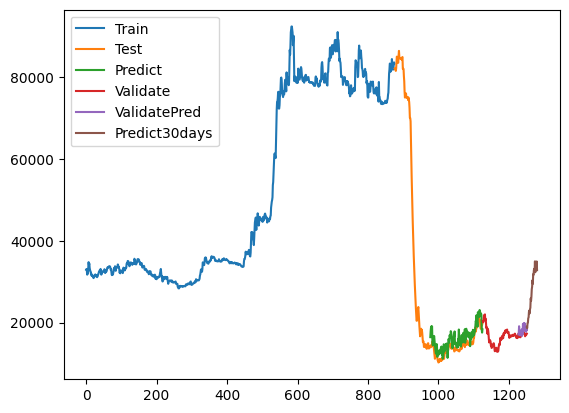

In [44]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# 3. NLG Dataset

In [45]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('3-NLG Historical Data.csv')
df_reversed = df.iloc[::-1].reset_index(drop=True)
df1 = df_reversed['Price']
# Remove commas and convert to float
df1 = df1.str.replace(',', '').astype(float)
df1

0       18706.8
1       19127.2
2       18917.0
3       18846.9
4       18706.8
         ...   
1247    37400.0
1248    38500.0
1249    38200.0
1250    39600.0
1251    39900.0
Name: Price, Length: 1252, dtype: float64

In [47]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [48]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [49]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [50]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [51]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [52]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [53]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 40ms/step - loss: 0.0089 - val_loss: 0.0019
Epoch 2/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 3/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 5/100
13/13 [==============================] - 0s 21ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 7/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/100
13/13 [==============================] - 0s 21ms/step - loss: 9.6243e-04 - val_loss: 9.1350e-04
Epoch 10/100
13/13 [==============================] - 0s 19ms/step - loss: 9.4766e-04 - val_

In [54]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 24ms/step


In [55]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [56]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 39340.64777641453
Testing RMSE: 32089.161869376574


In [57]:
# 13. Dự báo 30 ngày tiếp theo
x_input = val_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

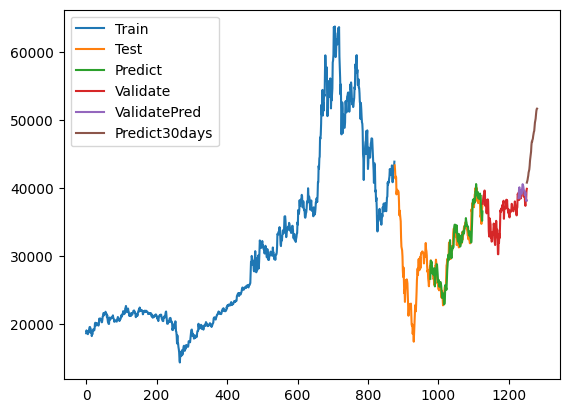

In [58]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()